In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from collections import Counter

# visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# NLP
import langdetect
import nltk
import readability
import spacy

# pip install --no-cache-dir https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-2.3.1/en_core_web_lg-2.3.1.tar.gz
# python -m spacy download en_core_web_lg
import en_core_web_lg

# ML
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

# Stats
from scipy.stats import pearsonr

import string

from utils import plot_distribution, plot_scatter_grid, print_max_feature_info, print_min_feature_info

In [3]:
# Setup
# Spacy model
nlp = en_core_web_lg.load()

# NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/hvelichkov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hvelichkov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/hvelichkov/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hvelichkov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Readability Assement
### Using regression model to calculate readability score

## Introduction

Extracting features from set of excerpts and training a model which predicts readability score. 

## What is readability score


Readability is the ease with which a reader can understand a written text. Numeric readability metrics (also known as readability tests or readability formulas) for natural language tend to use simple measures like word length (by letter or syllable), sentence length, and sometimes some measure of word frequency. 

## Reading the data

The data is provided in [Kaggle Commotlit competition](https://www.kaggle.com/c/commonlitreadabilityprize/). 

Files:
 - data/commonlitreadability.csv
 
Colums:
 - id - unique ID for excerpt
 - url_legal - URL of source - this is blank in the test set.
 - license - license of source material - this is blank in the test set.
 - excerpt - text to predict reading ease of
 - target - reading ease. Higher value means easier to read the excerpt
 - standard_error - measure of spread of scores among multiple raters for each excerpt.
 
I'm going to use only excerpt and target columns. 


In [4]:
# reading the training set
readability_data = pd.read_csv("data/commonlitreadability.csv", index_col=0)

## Data exploration

In [5]:
readability_data.head()

,url_legal,license,excerpt,target,standard_error
id,,,,,
c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [6]:
readability_data.shape

(2834, 5)

In [7]:
readability_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2834 entries, c12129c31 to 5b990ba77
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url_legal       830 non-null    object 
 1   license         830 non-null    object 
 2   excerpt         2834 non-null   object 
 3   target          2834 non-null   float64
 4   standard_error  2834 non-null   float64
dtypes: float64(2), object(3)
memory usage: 132.8+ KB


The type of the columns are correct. Most of the records in *url_legal* and *license* are NULL

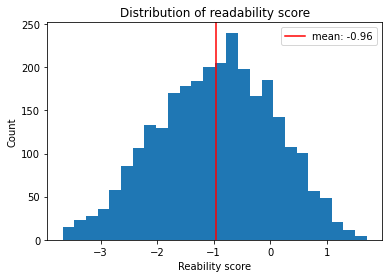

In [8]:
plot_distribution(readability_data.target, "Distribution of readability score", "Reability score")

*target* has normal distribution with average -0.96

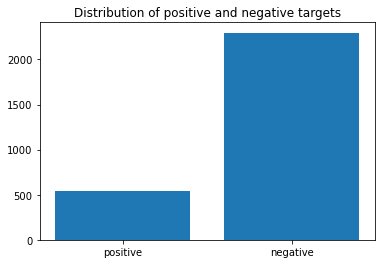

In [9]:
positive = (readability_data.target >= 0).sum()
negative = (readability_data.target < 0).sum()

plt.bar(["positive", "negative"], [positive, negative])

plt.title("Distribution of positive and negative targets")

plt.show()

Negative values are more than positive ones i.e. there are more difficult excerpts

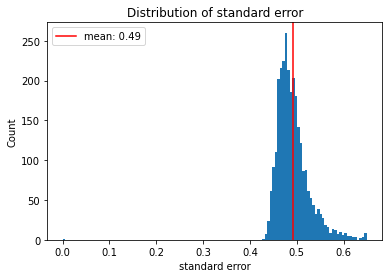

In [10]:
plot_distribution(readability_data.standard_error, "Distribution of standard error", "standard error")

In [11]:
readability_data.standard_error.skew()

0.28662982501006673

*standard_error* has normal distribution. 

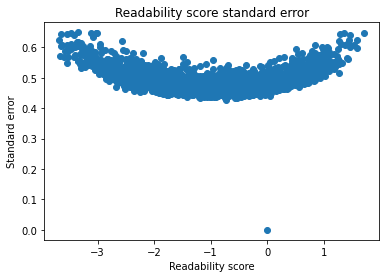

In [12]:
plt.scatter(readability_data.target, readability_data.standard_error)

plt.xlabel("Readability score")
plt.ylabel("Standard error")

plt.title("Readability score standard error")
plt.show()

In [13]:
(readability_data.standard_error == 0).sum()

1

Readability scores around -1 have lowest standard error. Also there is an excerpt with readability score 0 and standard error 0. 

In [14]:
readability_data.describe()

,target,standard_error
count,2834.000000,2834.000000
mean,-0.959319,0.491435
std,1.033579,0.034818
min,-3.676268,0.000000
25%,-1.690320,0.468543
50%,-0.912190,0.484721
75%,-0.202540,0.506268
max,1.711390,0.649671


The easiest excerpt has readability score 1.711390, the most difficult -3.676268

Let's examine some of the experts:

In [15]:
print(readability_data.loc[readability_data.target.idxmax(), "excerpt"])

When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?
This surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.
One of those surprising fossil beds is a place called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to Antarctica. Both continents were located near the South Pole. Today, paleontologists dig dinosaur fossils out of the ground. They think about what those ancient bones must mean.


In [16]:
print(readability_data.loc[readability_data.target.idxmin(), "excerpt"])

The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be found. These three segments are made so as to be removable in a moment for cleaning or replacement. They are mounted upon a metal support, and are surrounded on all sides by a free air space, and cannot, therefore, lose their insulated condition. This feature of air insulation is peculiar to this system, and is very important as a factor in the durability of the commutator. Besides this, the commutator is sustained by supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are coated all over with hard rubber, one of the finest known insulators. It may be stated, without fear of contradiction, that no other commutator made is so thoroughly insulated and protected. The three commutator segments virtually constitute a single copper ring, mounted in

In [17]:
around_mean_mask =  (readability_data.target >= (readability_data.target.mean() - 0.005))  &  (readability_data.target <= (readability_data.target.mean() + 0.005))

for excerpt in readability_data.loc[around_mean_mask, "excerpt"][:2]:
    print(excerpt)
    print()

Though he was thoughtful beyond his years and had shown unusual poetic power, young Bryant was in other ways quite an ordinary boy. He was quiet and studious in the school room, but was active enough in the games played outside. Of the sports enjoyed by himself and the other boys of the district school, he writes: "We amused ourselves with building dams across the rivulet, and launching rafts made of old boards on the collected water; and in winter, with sliding on the ice and building snow barricades, which we called forts, and, dividing the boys into two armies, and using snowballs for ammunition, we contended for the possession of these strongholds. I was one of their swiftest runners in the race, and not inexpert at playing ball, but, being of a slight frame, I did not distinguish myself in these sieges." Sometimes, on long evenings, Cullen and his elder brother Austin would play that they were the heroes of whom they had read in the Iliad, and, fitted out with swords and spears an

In [18]:
outlier = readability_data[(readability_data.target == 0) & (readability_data.standard_error == 0)]

In [19]:
print(outlier.excerpt[0])

The sun was shining in a cloudless sky, and no shadows lay on the mountain, and all day long they watched and waited, and at last, when the birds were singing their farewell song to the evening star, the children saw the shadows marching from the glen, trooping up the mountain side and dimming the purple of the heather.
And when the mountain top gleamed like a golden spear, they fixed their eyes on the line between the shadow and the sunshine.
"Now," said Connla, "the time has come."
"Oh, look! look!" said Nora, and as she spoke, just above the line of shadow a door opened out, and through its portals came a little piper dressed in green and gold. He stepped down, followed by another and another, until they were nine in all, and then the door slung back again.


# Data cleaning

Using only *excerpt* and *target* columns because *standard_error* can not be calculated for new observations, *url_legal* and *license* columns contain a lot of NULL values. Also drop record with target 0 and standard error 0

In [20]:
readability_data = readability_data[["excerpt", "target"]]
readability_data = readability_data.drop(outlier.index)

# Data validation

Cheking if there are any NULL values and if all excerpts are in English language

In [21]:
# Check if the outlier is droped
assert(outlier.index.values not in readability_data.index.values)

# Check if there are any NaN target
assert(False == readability_data.target.isna().any())

# Check if there are any duplicated and non valid excerpts
assert(False == readability_data.excerpt.isna().any())
assert(False == readability_data.excerpt.duplicated().any())

# Check if all excerpts are in English language
assert(True == (readability_data.excerpt.map(langdetect.detect) == 'en').all())

# Features extraction and exploration

Calculating different numerical metrics based on excerpts:
 - Readability grades
 - Syntactic properties
 - Part of the speech 
 - Word vectorization

Explore features with highest correlation with the *target*

Check if correlation is significant using hypothesis testing using p-value returned by scipy.stats.pearsonr

For all features hypothesis are:

- Null Hypothesis ($ H_0 $) : The population correlation coefficient IS NOT significantly different from zero. There IS NOT a significant linear relationship between *feature* and *target* in the population


- Alternative Hypotesis ($ H_a $) : The population
correlation coefficient IS significantly DIFFERENT FROM zero. There IS a significant linear relationship between *feature* and *target* in the population


Using significance level of $ 5\% $, $ \alpha = 0.05 $

## Syntactic properties

In [22]:
def get_syntactic_properties(excerpt):
    """ Calculate count of different syntactic properties for an excerpt"""
    return pd.Series(readability.getmeasures(excerpt)["sentence info"])

readability_syntactic = readability_data.excerpt.apply(get_syntactic_properties)

# all excerpts has 1 paragraph and sentences_per_paragraph so drop the column
readability_syntactic = readability_syntactic.drop(["paragraphs", "sentences_per_paragraph"], axis=1)

readability_syntactic["target"] = readability_data.target

readability_syntactic.head()

,characters_per_word,syll_per_word,words_per_sentence,type_token_ratio,characters,syllables,words,wordtypes,sentences,long_words,complex_words,complex_words_dc,target
id,,,,,,,,,,,,,
c12129c31,4.407821,1.234637,29.833333,0.608939,789.0,221.0,179.0,109.0,6.0,32.0,17.0,42.0,-0.340259
85aa80a4c,4.145349,1.197674,28.666667,0.674419,713.0,206.0,172.0,116.0,6.0,26.0,12.0,28.0,-0.315372
b69ac6792,4.105882,1.211765,34.000000,0.711765,698.0,206.0,170.0,121.0,5.0,26.0,14.0,41.0,-0.580118
dd1000b26,4.365854,1.189024,82.000000,0.670732,716.0,195.0,164.0,110.0,2.0,25.0,4.0,33.0,-1.054013
37c1b32fb,3.734694,1.027211,147.000000,0.326531,549.0,151.0,147.0,48.0,1.0,6.0,4.0,7.0,0.247197


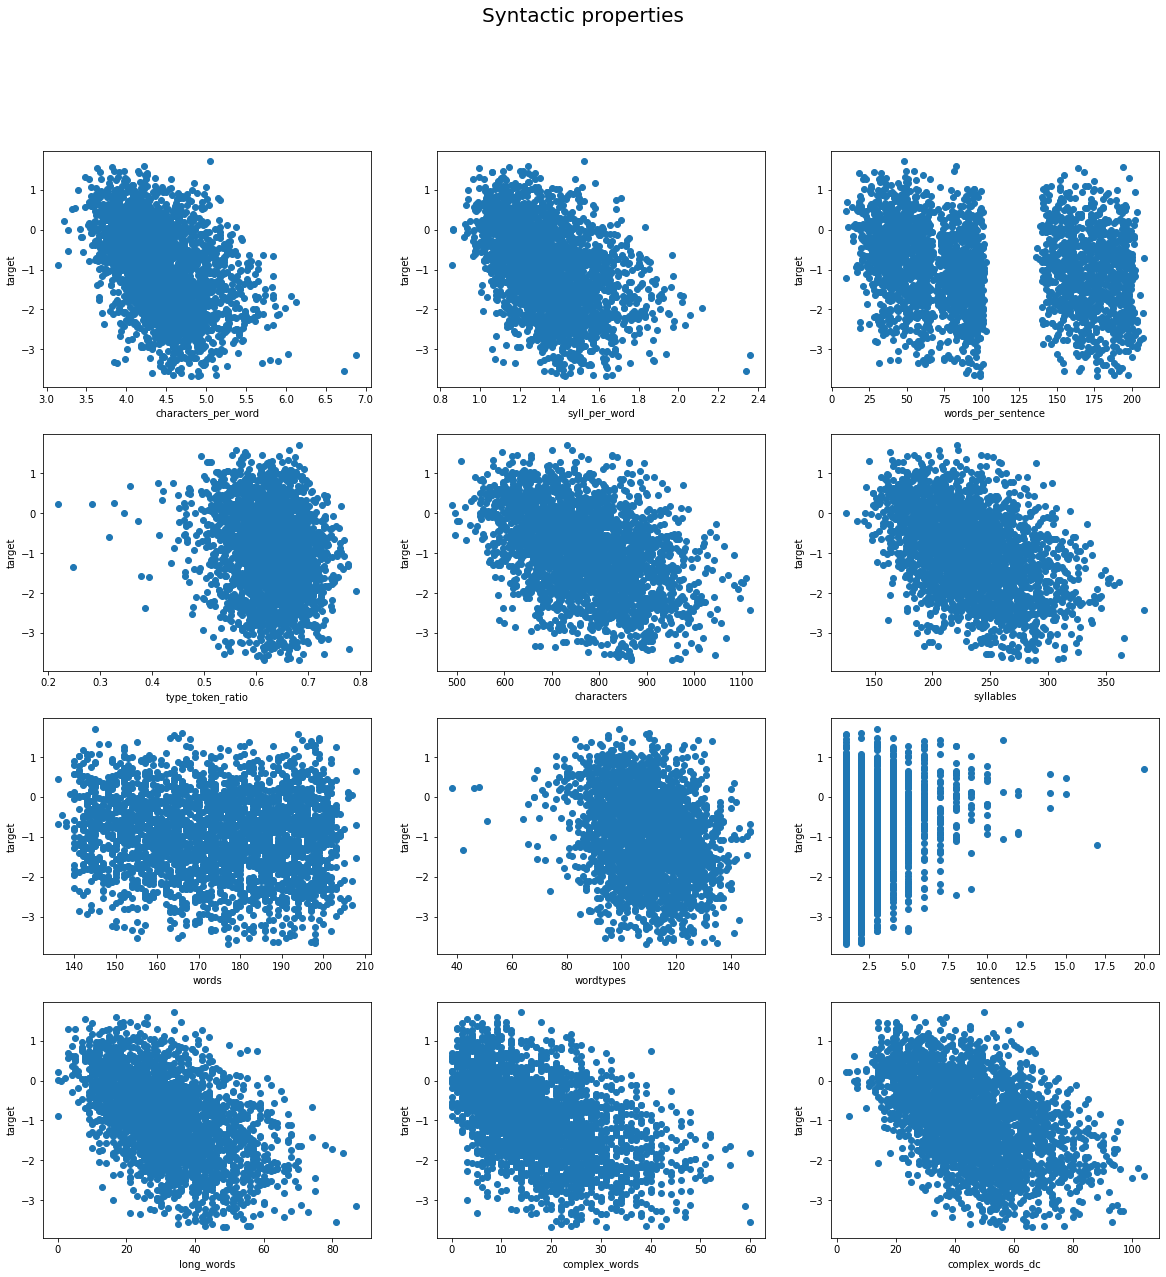

In [23]:
plot_scatter_grid(readability_syntactic, 
                  ["characters_per_word", "syll_per_word", "words_per_sentence",
                   "type_token_ratio", "characters", "syllables", "words", 
                   "wordtypes", "sentences", "long_words", "complex_words",
                   "complex_words_dc"],
                  "target", 4, 3, "Syntactic properties")

There is correlation between some of the properties and *target*.  

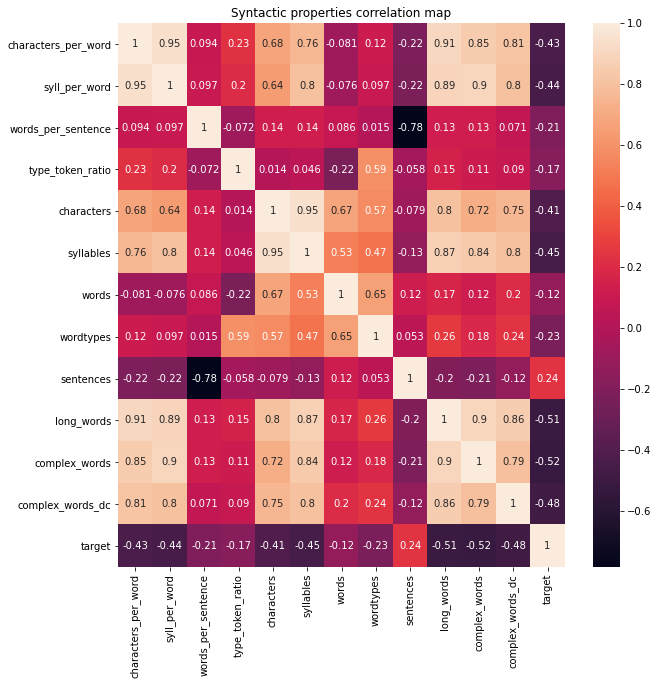

In [24]:
plt.figure(figsize=(10, 10))
sns.heatmap(readability_syntactic.corr(), annot=True)
plt.title("Syntactic properties correlation map")
plt.show()

Count of complex words and count of long words have highest correlation with the *target*. This seems logical because the more complex words the more difficult for reading is the exceprt.

### Complex words

Complex words are words with more than 3 syllables

In [25]:
readability_syntactic.complex_words.describe()

count    2833.000000
mean       17.172962
std        10.563790
min         0.000000
25%         9.000000
50%        15.000000
75%        24.000000
max        60.000000
Name: complex_words, dtype: float64

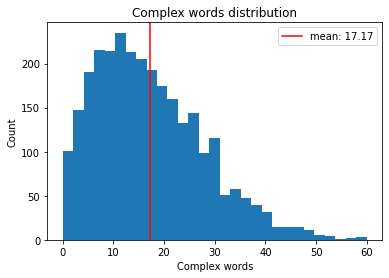

In [26]:
plot_distribution(readability_syntactic.complex_words, 'Complex words distribution', 'Complex words')

In [27]:
readability_syntactic.complex_words.skew()

0.7868120326659703

Distribution is right skewed with average value around 17 complex words

In [28]:
pearsonr(readability_syntactic.complex_words, readability_syntactic.target)

(-0.5169679838979692, 2.004819602176826e-193)

p_value is less that $\alpha = 0.05 $ so null hypothesis ($ H_0 $ ) could be rejected 

In [29]:
print_min_feature_info(readability_data, readability_syntactic.complex_words)

target: 0.230335717
complex_words : 0.0
Excerpt:
 This is Cat. This is Dog. Cat and Dog live in a house. A house with a door. A house with a roof. Cat and Dog have a ball. The ball is red and blue and green. Cat and Dog play with the ball. Cat throws the ball to Dog. Dog catches the ball. Dog throws the ball to Cat. Cat catches the ball. Then Cat throws the ball very high. Oh! oh! The ball is on the roof. The ball is on the roof of the house. Cat and Dog can see the ball. Cat and Dog cannot get to the ball. Cat and Dog cry. Then Elephant comes by. Elephant is big. Elephant can see the ball. Elephant can get to the ball. Elephant gets the ball from the roof. Elephant takes the ball from the roof of the house. Elephant gives the ball to Cat and Dog. Cat and Dog smile. Elephant smiles. Cat and Dog and Elephant smile.


In [30]:
print_max_feature_info(readability_data, readability_syntactic.complex_words)

target: -1.809957128
complex_words : 60.0
Excerpt:
 Civil engineering is the application of physical and scientific principles for solving the problems of society, and its history is intricately linked to advances in the understanding of physics and mathematics throughout history. Because civil engineering is a wide-ranging profession, including several specialized sub-disciplines, its history is linked to knowledge of structures, materials science, geography, geology, soils, hydrology, environment, mechanics and other fields.
Throughout ancient and medieval history most architectural design and construction was carried out by artisans, such as stonemasons and carpenters, rising to the role of master builder. Knowledge was retained in guilds and seldom supplanted by advances. Structures, roads, and infrastructure that existed were repetitive, and increases in scale were incremental.
One of the earliest examples of a scientific approach to physical and mathematical problems applicable t

The excerpt with maximum count of  complex words seems more difficult than the out without complex words

### Long words

Longs words are words with more than 7 characters

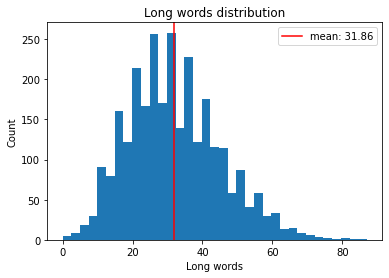

In [31]:
plot_distribution(readability_syntactic.long_words, 'Long words distribution', 'Long words')

In [32]:
readability_syntactic.long_words.skew()

0.4876324703678499

Distribution is normal with average value around 32 long words

In [33]:
readability_syntactic.long_words.describe()

count    2833.000000
mean       31.857748
std        13.301768
min         0.000000
25%        22.000000
50%        30.000000
75%        40.000000
max        87.000000
Name: long_words, dtype: float64

In [34]:
pearsonr(readability_syntactic.long_words, readability_syntactic.target)

(-0.510151067490926, 1.4261392143753437e-187)

p_value is less that $\alpha = 0.05 $ so null hypothesis ($ H_0 $ ) could be rejected 

In [35]:
print_min_feature_info(readability_data, readability_syntactic.long_words)

target: 0.006880764
long_words : 0.0
Excerpt:
 The horse and the cow, in great grief, came and stood by the side of the white sheep as he lay on the grass. They were fond of him in spite of all his faults. "Oh, why!" cried the cow, with tears in her eyes (and the bell that was hung round her neck shook and rang as she leaned over him),—"why did you leave the field with the black sheep?"
"He did it first," said the white one in a faint voice.
"Then why did you jump down that steep place? Could you not see that it was a pit?"
"I did not stop to see. He did it first," said the white sheep. Then, with a groan, he went on to ask, "How is the black sheep? Is he here too? And what does the man think who comes to see us?"


In [36]:
print_max_feature_info(readability_data, readability_syntactic.long_words)

target: -3.137143261
long_words : 87.0
Excerpt:
 Environmental science is an interdisciplinary academic field that integrates physical, biological and information sciences (including ecology, biology, physics, chemistry, zoology, mineralogy, oceanology, limnology, soil science, geology, atmospheric science, and geodesy) to the study of the environment, and the solution of environmental problems. Environmental science emerged from the fields of natural history and medicine during the Enlightenment. Today it provides an integrated, quantitative, and interdisciplinary approach to the study of environmental systems.
Related areas of study include environmental studies and environmental engineering. Environmental studies incorporate more of the social sciences for understanding human relationships, perceptions and policies towards the environment. Environmental engineering focuses on design and technology for improving environmental quality in every aspect. Environmental scientists work on 

The excerpt with maximum count of  long words seems more difficult than the one without complex words

In [37]:
readability_syntactic.nlargest(5, "target")

,characters_per_word,syll_per_word,words_per_sentence,type_token_ratio,characters,syllables,words,wordtypes,sentences,long_words,complex_words,complex_words_dc,target
id,,,,,,,,,,,,,
25ca8f498,5.048276,1.524138,48.333333,0.682759,732.0,221.0,145.0,99.0,3.0,34.0,14.0,50.0,1.711390
849971671,4.216867,1.240964,83.000000,0.662651,700.0,206.0,166.0,110.0,2.0,26.0,9.0,37.0,1.597870
8f35441e3,3.824742,1.144330,194.000000,0.561856,742.0,222.0,194.0,109.0,1.0,17.0,5.0,26.0,1.583847
7a1d484be,3.628049,0.993902,164.000000,0.579268,595.0,163.0,164.0,95.0,1.0,8.0,3.0,35.0,1.541672
016913371,4.150754,1.216080,49.750000,0.552764,826.0,242.0,199.0,110.0,4.0,36.0,18.0,30.0,1.467665


In [38]:
readability_syntactic.nsmallest(5, "target")

,characters_per_word,syll_per_word,words_per_sentence,type_token_ratio,characters,syllables,words,wordtypes,sentences,long_words,complex_words,complex_words_dc,target
id,,,,,,,,,,,,,
4626100d8,4.898305,1.632768,177.0,0.615819,867.0,289.0,177.0,109.0,1.0,48.0,31.0,56.0,-3.676268
493b80aa7,4.813131,1.429293,99.0,0.681818,953.0,283.0,198.0,135.0,2.0,49.0,20.0,66.0,-3.668360
fe44cbd14,4.928934,1.568528,197.0,0.659898,971.0,309.0,197.0,130.0,1.0,56.0,39.0,77.0,-3.642892
284eaa5ad,5.127660,1.664894,188.0,0.664894,964.0,313.0,188.0,125.0,1.0,55.0,42.0,70.0,-3.639936
9e9eacb49,4.587302,1.417989,94.5,0.613757,867.0,268.0,189.0,116.0,2.0,43.0,24.0,64.0,-3.636834


Most difficult excerpts have more complex and long words

## Readability grades

There are various readability grades which calculates readability score:

- [Flesch–Kincaid](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests)
- [Flesch Reading Ease](https://simple.wikipedia.org/wiki/Flesch_Reading_Ease)
- [Automated readability index](https://en.wikipedia.org/wiki/Automated_readability_index)
- [Coleman–Liau index](https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index)
- [Gunning fog index](https://en.wikipedia.org/wiki/Gunning_fog_index)
- [LIX](https://en.wikipedia.org/wiki/Lix_(readability_test)
- [SMOG index](https://en.wikipedia.org/wiki/SMOG)
- [RIX](https://readable.com/features/readability-formulas/#rix)
- [Dale–Chall](https://en.wikipedia.org/wiki/Dale–Chall_readability_formula)

In [39]:
def get_readability_grades(excerpt):
    """ Calcuate different readability grades for an exceprt """
    return pd.Series(readability.getmeasures(excerpt)["readability grades"])

readability_grades = readability_data.excerpt.apply(get_readability_grades)
readability_grades["target"] = readability_data.target
readability_grades.head()

,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex,target
id,,,,,,,,,,
c12129c31,10.613715,14.247505,9.124776,72.103887,15.732216,47.710428,12.219544,5.333333,8.821150,-0.340259
85aa80a4c,9.722558,12.427926,7.541115,76.415078,14.257364,43.782946,10.745967,4.333333,7.628832,-0.315372
b69ac6792,11.968824,14.908706,7.470958,69.809706,16.894118,49.294118,12.165151,5.200000,9.131076,-0.580118
dd1000b26,30.420488,40.133171,9.508945,23.013537,33.775610,97.243902,10.745967,12.500000,10.880956,-1.054013
37c1b32fb,53.861088,69.660408,5.957366,-29.272041,59.888435,151.081633,13.954451,6.000000,0.000000,0.247197


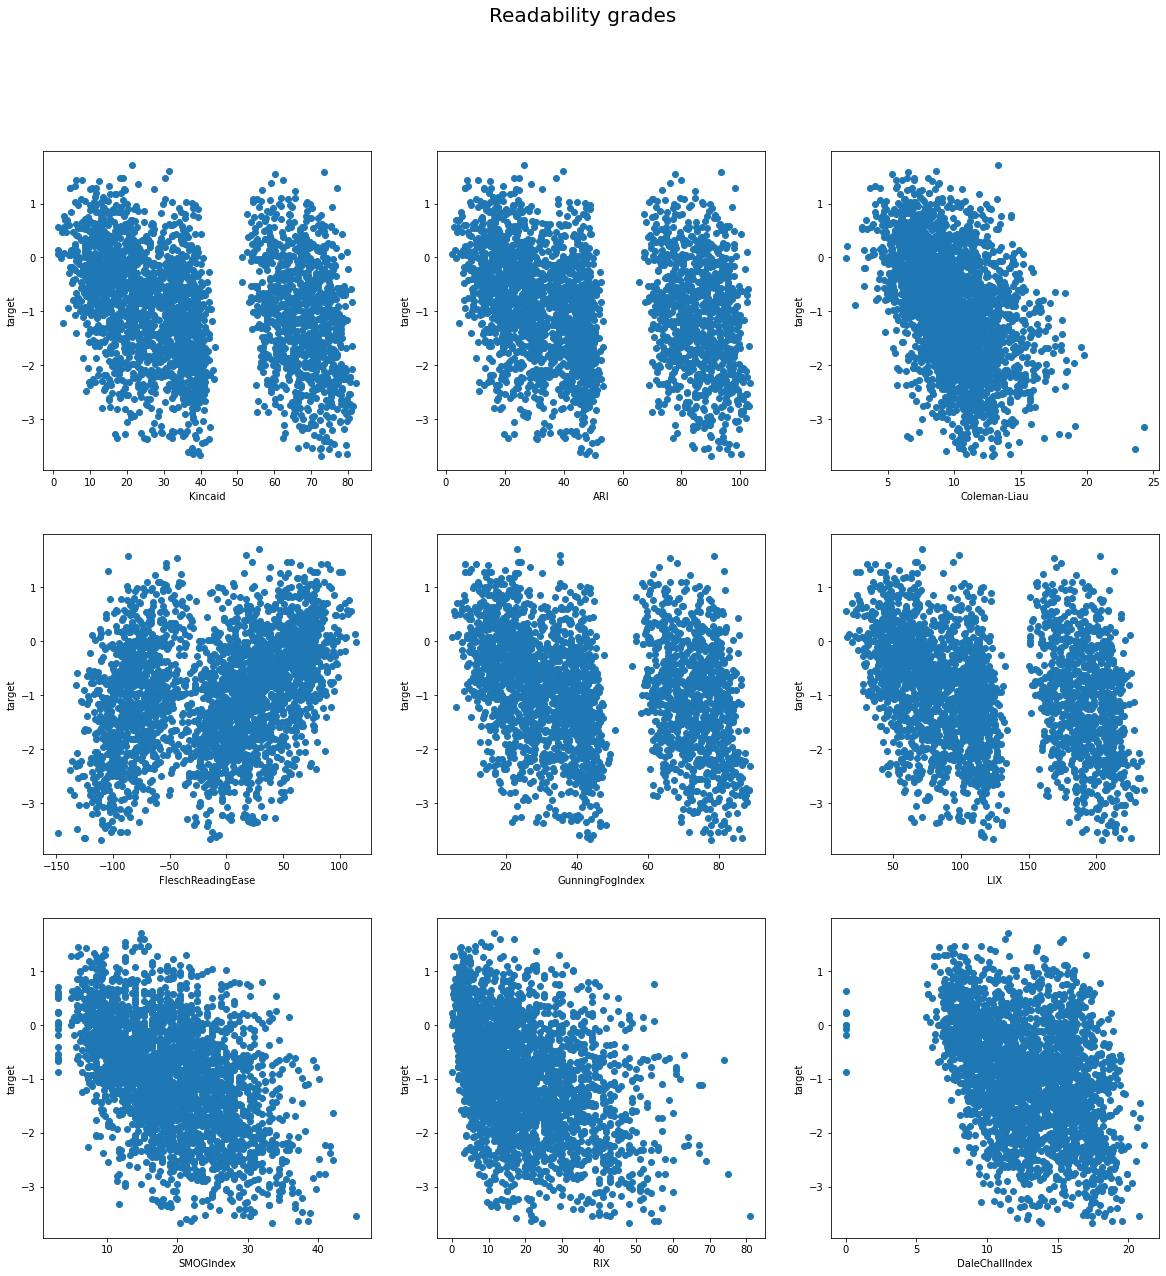

In [40]:
plot_scatter_grid(readability_grades, 
                  ["Kincaid", "ARI", "Coleman-Liau", 
                   "FleschReadingEase", "GunningFogIndex", "LIX", 
                   "SMOGIndex", "RIX", "DaleChallIndex"], 
                  "target", 3, 3, "Readability grades")

There is some correlation between readability grades and target. Some of the grades form clusters.

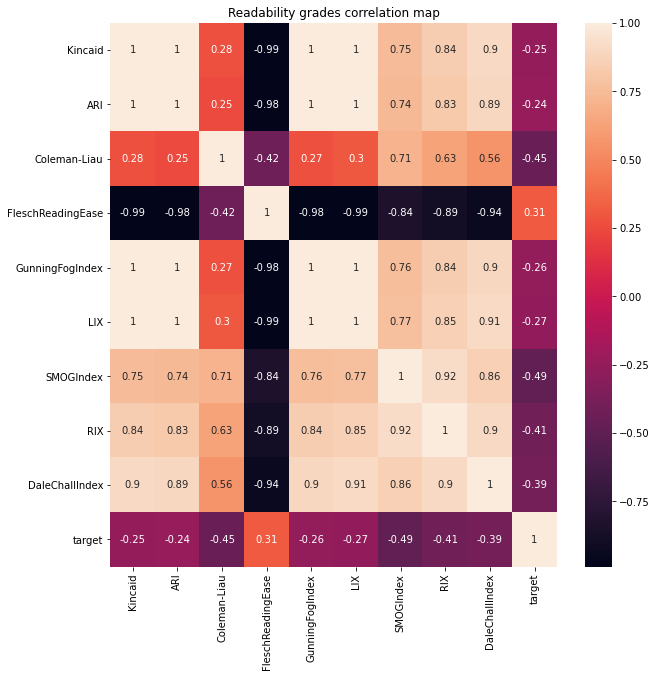

In [41]:
plt.figure(figsize=(10, 10))
sns.heatmap(readability_grades.corr(), annot=True)
plt.title("Readability grades correlation map")
plt.show()

There is high correlation between different readability grades, which is expected, because similar metrics are used for calculating them. *SMOGindex*, *Coleman-Liau*, *RIX* and *DaleChallIndex* have highest correlation with the *target* variable.

### SMOG index

The [SMOG index](https://en.wikipedia.org/wiki/SMOG) is a measure of readability that estimates the years of education needed to understand a piece of writing. SMOG is an acronym for "Simple Measure of Gobbledygook".

The formula needs at least 30 sentences so let's first check sentence count

In [42]:
(readability_syntactic.sentences >= 30).sum()

0

Regardless that the dataset does not contains excerpts with at least 30 sentences, let's us explore the grade

In [43]:
readability_grades.SMOGIndex.describe()

count    2833.000000
mean       19.110505
std         7.450940
min         3.000000
25%        13.488088
50%        18.491933
75%        24.213203
max        45.426407
Name: SMOGIndex, dtype: float64

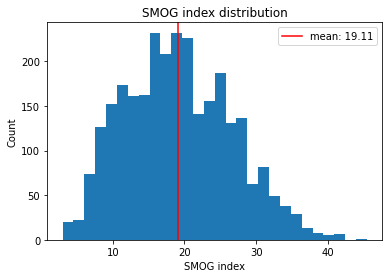

In [44]:
plot_distribution(readability_grades.SMOGIndex, 'SMOG index distribution', 'SMOG index')

In [45]:
readability_grades.SMOGIndex.skew()

0.2878192649497767

Distribution is normal with average value around 19

In [46]:
print_min_feature_info(readability_data, readability_grades.SMOGIndex)

target: 0.230335717
SMOGIndex : 3.0
Excerpt:
 This is Cat. This is Dog. Cat and Dog live in a house. A house with a door. A house with a roof. Cat and Dog have a ball. The ball is red and blue and green. Cat and Dog play with the ball. Cat throws the ball to Dog. Dog catches the ball. Dog throws the ball to Cat. Cat catches the ball. Then Cat throws the ball very high. Oh! oh! The ball is on the roof. The ball is on the roof of the house. Cat and Dog can see the ball. Cat and Dog cannot get to the ball. Cat and Dog cry. Then Elephant comes by. Elephant is big. Elephant can see the ball. Elephant can get to the ball. Elephant gets the ball from the roof. Elephant takes the ball from the roof of the house. Elephant gives the ball to Cat and Dog. Cat and Dog smile. Elephant smiles. Cat and Dog and Elephant smile.


In [47]:
print_max_feature_info(readability_data, readability_grades.SMOGIndex)

target: -3.549190203
SMOGIndex : 45.42640687119285
Excerpt:
 Molecular nanotechnology (MNT) is a technology based on the ability to build structures to complex, atomic specifications by means of mechanosynthesis. This is distinct from nanoscale materials. Based on Richard Feynman's vision of miniature factories using nanomachines to build complex products (including additional nanomachines), this advanced form of nanotechnology (or molecular manufacturing) would make use of positionally-controlled mechanosynthesis guided by molecular machine systems. MNT would involve combining physical principles demonstrated by biophysics, chemistry, other nanotechnologies, and the molecular machinery of life with the systems engineering principles found in modern macroscale factories. While conventional chemistry uses inexact processes obtaining inexact results, and biology exploits inexact processes to obtain definitive results, molecular nanotechnology would employ original definitive processes to

According the SMOG index, the easiest excerpt has score 3.0, the most difficult 45.43. Comparing to the *target*, they are not easiest and most difficult ones. It seems that excerpt with smallest SMOG index is easy to read and the one with highest is difficult.

In [48]:
pearsonr(readability_grades.SMOGIndex, readability_grades.target)

(-0.48801203299744667, 1.8561560862786532e-169)

p_value is less that $\alpha = 0.05 $ so null hypothesis ($ H_0 $ ) could be rejected 

### RIX formula

[RIX formula](https://readable.com/blog/the-lix-and-rix-readability-formulas/) measures readability based on letter counting

In [49]:
readability_grades.RIX.describe()

count    2833.000000
mean       19.209112
std        13.359009
min         0.000000
25%         8.500000
50%        16.000000
75%        27.500000
max        81.000000
Name: RIX, dtype: float64

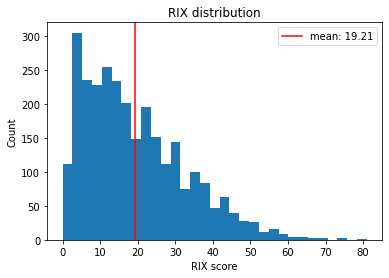

In [50]:
plot_distribution(readability_grades.RIX, 'RIX distribution', 'RIX score')

In [51]:
readability_grades.RIX.skew()

0.8911877584530148

The distribution is right skewed with average around 19

In [52]:
print_min_feature_info(readability_data, readability_grades.RIX)

target: 0.006880764
RIX : 0.0
Excerpt:
 The horse and the cow, in great grief, came and stood by the side of the white sheep as he lay on the grass. They were fond of him in spite of all his faults. "Oh, why!" cried the cow, with tears in her eyes (and the bell that was hung round her neck shook and rang as she leaned over him),—"why did you leave the field with the black sheep?"
"He did it first," said the white one in a faint voice.
"Then why did you jump down that steep place? Could you not see that it was a pit?"
"I did not stop to see. He did it first," said the white sheep. Then, with a groan, he went on to ask, "How is the black sheep? Is he here too? And what does the man think who comes to see us?"


In [53]:
print_max_feature_info(readability_data, readability_grades.RIX)

target: -3.549190203
RIX : 81.0
Excerpt:
 Molecular nanotechnology (MNT) is a technology based on the ability to build structures to complex, atomic specifications by means of mechanosynthesis. This is distinct from nanoscale materials. Based on Richard Feynman's vision of miniature factories using nanomachines to build complex products (including additional nanomachines), this advanced form of nanotechnology (or molecular manufacturing) would make use of positionally-controlled mechanosynthesis guided by molecular machine systems. MNT would involve combining physical principles demonstrated by biophysics, chemistry, other nanotechnologies, and the molecular machinery of life with the systems engineering principles found in modern macroscale factories. While conventional chemistry uses inexact processes obtaining inexact results, and biology exploits inexact processes to obtain definitive results, molecular nanotechnology would employ original definitive processes to obtain definitive 

According to RIX score, the easiest excerpt has score 0.0069, the most difficult 81. Comparing to the *target*, they are not easiest and most difficult ones. It seems that excerpt with smallest RIX is easy to read and the one with highest is difficult.

In [54]:
pearsonr(readability_grades.RIX, readability_grades.target)

(-0.41027014969245196, 1.8155621711861335e-115)

p_value is less that $\alpha = 0.05 $ so null hypothesis ($ H_0 $ ) could be rejected 

### Coleman–Liau index

[Coleman–Liau index](https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index) is a readability test designed by Meri Coleman and T. L. Liau to gauge the understandability of a text. Like the Flesch–Kincaid Grade Level, Gunning fog index, SMOG index, and Automated Readability Index, its output approximates the U.S. grade level thought necessary to comprehend the text.

In [55]:
readability_grades["Coleman-Liau"].describe()

count    2833.000000
mean        9.824064
std         2.704274
min         1.828795
25%         7.929992
50%         9.675468
75%        11.509626
max        24.293560
Name: Coleman-Liau, dtype: float64

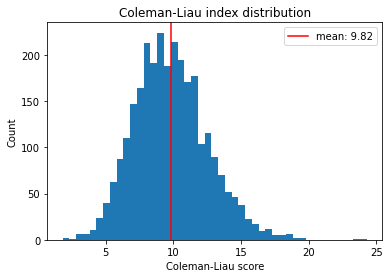

In [56]:
plot_distribution(readability_grades["Coleman-Liau"], 'Coleman-Liau index distribution', 'Coleman-Liau score')

In [57]:
readability_grades["Coleman-Liau"].skew()

0.4547249542616647

Distribution is normal with average value around 9

In [58]:
pearsonr(readability_grades["Coleman-Liau"], readability_grades.target)

(-0.4475704848621022, 1.2673558067657794e-139)

p_value is less that $\alpha = 0.05 $ so null hypothesis ($ H_0 $ ) could be rejected 

In [59]:
print_min_feature_info(readability_data, readability_grades["Coleman-Liau"])

target: -0.010102659
Coleman-Liau : 1.8287947352941174
Excerpt:
 A man tied his horse to a tree and went into an inn. A Thief hid the horse in a wood, and stood near the tree as if he had not done it.
"Did you see my horse?" said the man.
"Yes," said the Thief, "I saw the tree eat up your horse.''
"How could the tree eat up my horse?" said the man.
"Why it did so," said the Thief.
The two went to a Fox and told him of the case. The Fox said. "I am dull. All last night the sea was on fire; I had to throw a great deal of hay into it to quench the flames; so come tomorrow, and I shall hear your case.
"Oh, you lie," said the Thief. "How could the sea burn? How could hay quench the flames?"
"Oh, you lie," said the Fox, with a loud laugh; "how could a tree eat up a horse?"
The Thief saw his lie had no legs, and gave the man his horse.


In [60]:
print_max_feature_info(readability_data, readability_grades["Coleman-Liau"])

target: -3.137143261
Coleman-Liau : 24.29356023870968
Excerpt:
 Environmental science is an interdisciplinary academic field that integrates physical, biological and information sciences (including ecology, biology, physics, chemistry, zoology, mineralogy, oceanology, limnology, soil science, geology, atmospheric science, and geodesy) to the study of the environment, and the solution of environmental problems. Environmental science emerged from the fields of natural history and medicine during the Enlightenment. Today it provides an integrated, quantitative, and interdisciplinary approach to the study of environmental systems.
Related areas of study include environmental studies and environmental engineering. Environmental studies incorporate more of the social sciences for understanding human relationships, perceptions and policies towards the environment. Environmental engineering focuses on design and technology for improving environmental quality in every aspect. Environmental scie

According to Coleman-Liau index, the easiest excerpt has score 1.8287947352941174, the most difficult 24.29356023870968. Comparing to the *target*, they are not easiest and most difficult ones. It seems that excerpt with smallest score is easy to read and the one with highest is difficult.

Let's check readability grades for the easiest and most difficult excerpts

In [61]:
readability_grades.nlargest(5, "target")

,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex,target
id,,,,,,,,,,
25ca8f498,21.244828,26.514046,13.270155,28.834598,23.195402,71.781609,14.832160,11.333333,11.478661,1.711390
849971671,31.423373,39.931446,8.637275,17.604458,35.368675,98.662651,14.618950,13.000000,11.272758,1.597870
8f35441e3,73.573093,93.584536,6.535599,-86.885309,78.630928,202.762887,15.247449,17.000000,15.375086,1.583847
7a1d484be,60.098049,77.658110,5.351172,-43.709146,66.331707,168.878049,12.486833,8.000000,15.140717,1.541672
016913371,18.162249,22.995050,8.010291,53.458348,23.518090,67.840452,14.618950,9.000000,8.484502,1.467665


In [62]:
readability_grades.nsmallest(5, "target")

,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex,target
id,,,,,,,,,,
4626100d8,72.706667,90.141017,12.833340,-110.952203,77.805650,204.118644,33.495901,48.0,17.411406,-3.676268
493b80aa7,39.885657,50.739848,12.200830,-14.568182,43.640404,123.747475,20.320508,24.5,13.810233,-3.668360
fe44cbd14,79.748629,100.285279,13.030404,-125.817462,86.718782,225.426396,37.205263,56.0,19.579426,-3.642892
284eaa5ad,77.375745,96.721277,14.191691,-124.835000,84.136170,217.255319,38.496479,55.0,18.840555,-3.639936
9e9eacb49,37.997275,47.426190,10.858753,-9.044405,42.879365,117.251323,21.973666,21.5,13.670578,-3.636834


It is interesting that easiest excerpt has higher *Coleman-Liau* score than the most difficult one. Also it seems that grades for the more difficult excerpts are more accurate. So let's split the data with positive and negative targets and check the correlation with the *target*.

In [63]:
readability_grades_positive_target  = readability_grades[readability_grades.target >= 0]
readability_grades_negative_target  = readability_grades[readability_grades.target < 0]

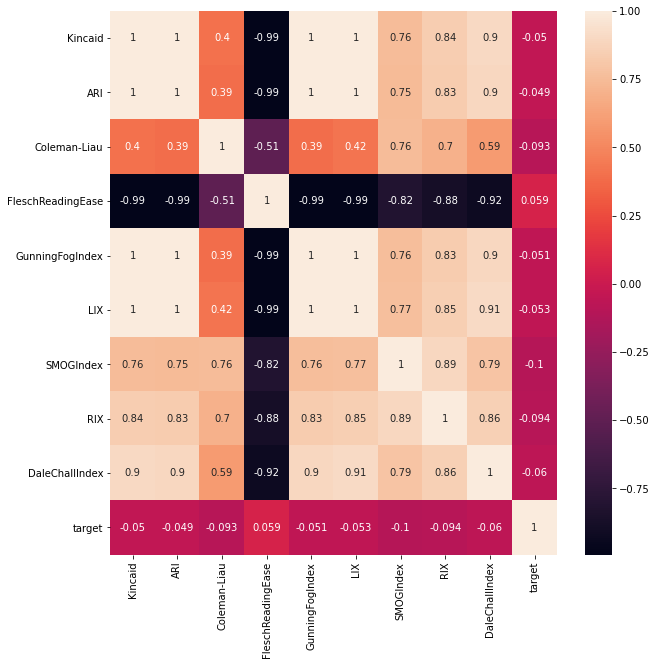

In [64]:
plt.figure(figsize=(10, 10))
sns.heatmap(readability_grades_positive_target.corr(), annot=True)
plt.show()

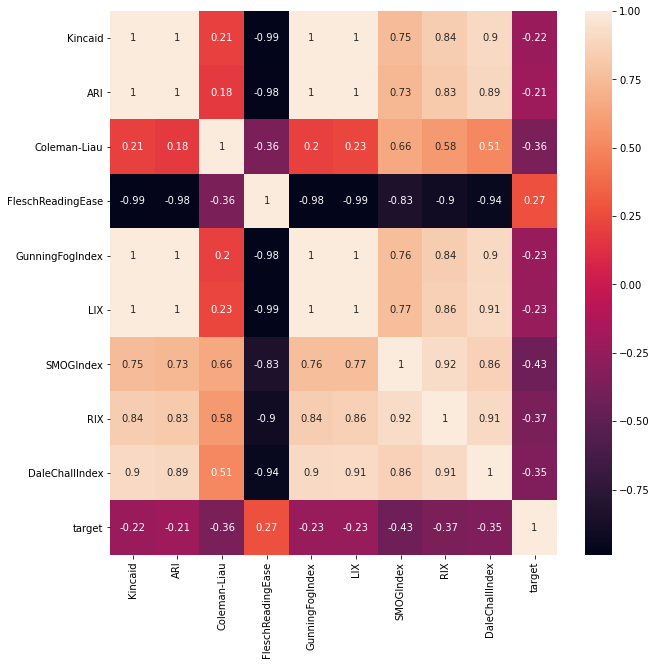

In [65]:
plt.figure(figsize=(10, 10))
sns.heatmap(readability_grades_negative_target.corr(), annot=True)
plt.show()

Readability grades for more difficult excerpts have higher correlation than the easier ones.

## Part of the speech

In [66]:
def get_pos_tags(excerpt):
    """ Extract count of POS tags for an excerpt"""
    pos_tags = nltk.pos_tag(nltk.word_tokenize(excerpt), tagset="universal")
    pos_tags_count = Counter([tag[1] for tag in pos_tags])
    return pd.Series(pos_tags_count)
    
readability_pos_tags = readability_data.excerpt.apply(get_pos_tags)
readability_pos_tags["target"] = readability_data.target

# rename columns
readability_pos_tags = readability_pos_tags.rename(columns={"." : "PUNC", "X" : "OTHER"})

readability_pos_tags.head()

,ADV,DET,ADJ,NOUN,VERB,PRT,PUNC,PRON,ADP,CONJ,NUM,OTHER,target
id,,,,,,,,,,,,,
c12129c31,6.0,34.0,13.0,48.0,35.0,3.0,25.0,4.0,21.0,11.0,4.0,NaN,-0.340259
85aa80a4c,16.0,11.0,13.0,32.0,43.0,7.0,51.0,29.0,13.0,7.0,NaN,1.0,-0.315372
b69ac6792,19.0,15.0,9.0,42.0,34.0,3.0,40.0,21.0,16.0,10.0,1.0,NaN,-0.580118
dd1000b26,2.0,20.0,16.0,52.0,19.0,2.0,30.0,12.0,23.0,15.0,3.0,NaN,-1.054013
37c1b32fb,2.0,32.0,13.0,51.0,10.0,2.0,28.0,7.0,17.0,10.0,3.0,NaN,0.247197


In [67]:
readability_pos_tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2833 entries, c12129c31 to 5b990ba77
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADV     2830 non-null   float64
 1   DET     2833 non-null   float64
 2   ADJ     2833 non-null   float64
 3   NOUN    2833 non-null   float64
 4   VERB    2833 non-null   float64
 5   PRT     2813 non-null   float64
 6   PUNC    2833 non-null   float64
 7   PRON    2793 non-null   float64
 8   ADP     2833 non-null   float64
 9   CONJ    2828 non-null   float64
 10  NUM     1989 non-null   float64
 11  OTHER   275 non-null    float64
 12  target  2833 non-null   float64
dtypes: float64(13)
memory usage: 374.4+ KB


In [68]:
# Drop OTHER column as there are a lot of NULL VALUES
readability_pos_tags = readability_pos_tags.drop("OTHER", axis=1)

# Fill NULL values with 0
readability_pos_tags = readability_pos_tags.fillna(0)

readability_pos_tags.head()

,ADV,DET,ADJ,NOUN,VERB,PRT,PUNC,PRON,ADP,CONJ,NUM,target
id,,,,,,,,,,,,
c12129c31,6.0,34.0,13.0,48.0,35.0,3.0,25.0,4.0,21.0,11.0,4.0,-0.340259
85aa80a4c,16.0,11.0,13.0,32.0,43.0,7.0,51.0,29.0,13.0,7.0,0.0,-0.315372
b69ac6792,19.0,15.0,9.0,42.0,34.0,3.0,40.0,21.0,16.0,10.0,1.0,-0.580118
dd1000b26,2.0,20.0,16.0,52.0,19.0,2.0,30.0,12.0,23.0,15.0,3.0,-1.054013
37c1b32fb,2.0,32.0,13.0,51.0,10.0,2.0,28.0,7.0,17.0,10.0,3.0,0.247197


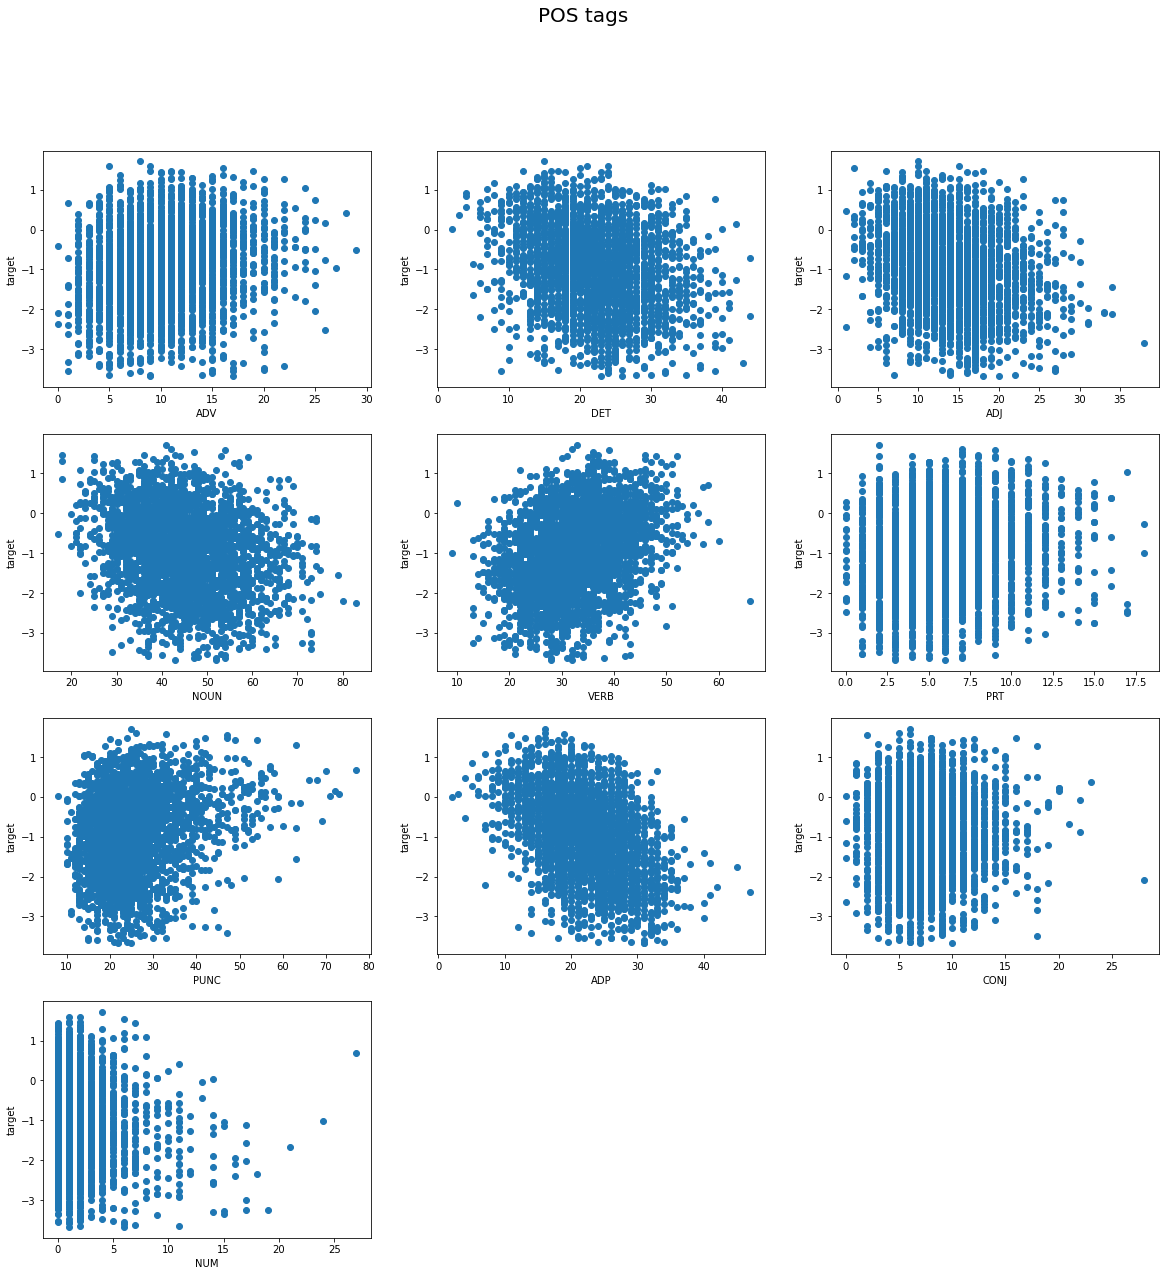

In [69]:
plot_scatter_grid(readability_pos_tags, 
                  ["ADV", "DET", "ADJ", "NOUN",
                   "VERB", "PRT", "PUNC", "ADP",
                  "CONJ", "NUM"], "target", 4, 3, "POS tags")

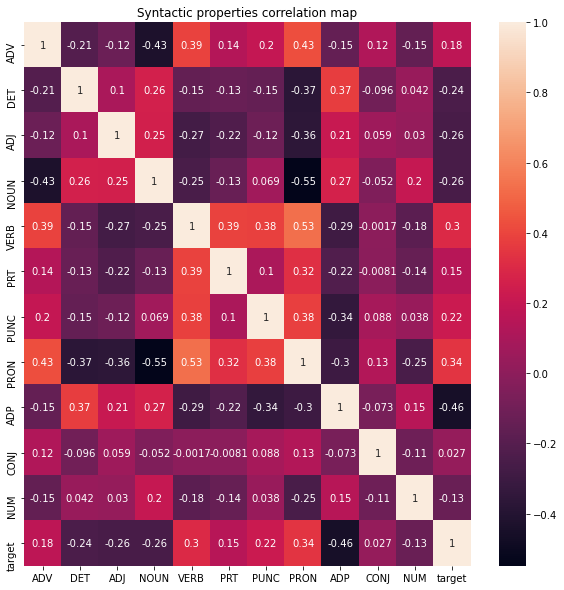

In [70]:
plt.figure(figsize=(10, 10))
sns.heatmap(readability_pos_tags.corr(), annot=True)
plt.title("Syntactic properties correlation map")
plt.show()

Adposition count has highest correlation with *target*

### Adposition

In [71]:
readability_pos_tags.ADP.describe()

count    2833.000000
mean       21.917755
std         5.785839
min         2.000000
25%        18.000000
50%        22.000000
75%        26.000000
max        47.000000
Name: ADP, dtype: float64

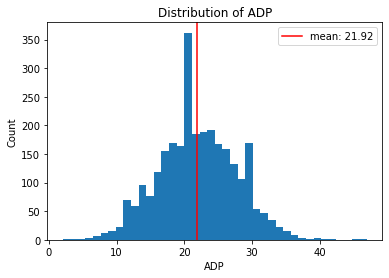

In [72]:
plot_distribution(readability_pos_tags.ADP, "Distribution of ADP", "ADP")

Distribution is normal with average value around 22.

In [73]:
pearsonr(readability_pos_tags.ADP, readability_pos_tags.target)

(-0.4566963493656095, 5.21701634261447e-146)

p_value is less that $\alpha = 0.05 $ so null hypothesis ($ H_0 $ ) could be rejected 

In [74]:
print_min_feature_info(readability_data, readability_pos_tags.ADP)

target: -0.003054017
ADP : 2.0
Excerpt:
 "The little girl wants a warm plaid dress. I will give my wool. Who else will help?"
The kind shepherd said, "I will." Then he led the old white sheep to the brook and washed its wool. When it was clean and white, he said, "The little girl wants a warm plaid dress. The sheep has given his wool, and I have washed it clean and white. Who else will help?"
"We will," said the shearers. "We will bring our shears and cut off the wool."
The shearers cut the soft wool from the old sheep, and then they called, "The little girl wants a new dress. The sheep has given his wool. The shepherd has washed it; and we have sheared it. Who else will help?"
"We will," cried the carders. "We will comb it out straight and smooth."
Soon they held up the wool, carded straight and smooth, and they cried, "The little girl wants a new dress. The sheep has given his wool. The shepherd has washed the wool. The shearers have cut it, and we have carded it. Who else will help?

In [75]:
print_max_feature_info(readability_data, readability_pos_tags.ADP)

target: -2.385984476
ADP : 47.0
Excerpt:
 One of the principal disadvantages of furnaces for revivifying animal charcoal has been that they possessed no automatic drier for drying the black on its exit from the washer. It was for the purpose of remedying this that Mr. Schreiber was led to invent the automatic system of drying shown at the upper part of the furnace, and which is formed of two pipes of undulating form, like the retorts, with openings throughout their length for the escape of steam. Between these pipes there is a closed space into which enters the waste heat and products of combustion from the furnace. These latter afterward escape through the chimney at the upper part.
In order that the black may be put in bags on issuing from the furnace, it must be cooled as much as possible. For this purpose there are arranged on each side of the furnace two pieces of cast iron tubes of rectangular section, forming a prolongation of the retorts and making with them an angle of about 4

The excerpt with maximum count of  adpositions seems more difficult than the one with minimum.

In [76]:
readability_pos_tags.nlargest(5, "target")

,ADV,DET,ADJ,NOUN,VERB,PRT,PUNC,PRON,ADP,CONJ,NUM,target
id,,,,,,,,,,,,
25ca8f498,8.0,15.0,10.0,41.0,33.0,2.0,25.0,9.0,16.0,6.0,4.0,1.711390
849971671,5.0,24.0,15.0,42.0,32.0,7.0,26.0,21.0,16.0,5.0,1.0,1.597870
8f35441e3,9.0,21.0,10.0,54.0,39.0,9.0,33.0,25.0,19.0,6.0,2.0,1.583847
7a1d484be,16.0,20.0,2.0,47.0,36.0,7.0,47.0,12.0,11.0,2.0,6.0,1.541672
016913371,9.0,16.0,18.0,43.0,46.0,7.0,47.0,34.0,16.0,8.0,2.0,1.467665


In [77]:
readability_pos_tags.nsmallest(5, "target")

,ADV,DET,ADJ,NOUN,VERB,PRT,PUNC,PRON,ADP,CONJ,NUM,target
id,,,,,,,,,,,,
4626100d8,9.0,23.0,20.0,43.0,32.0,3.0,25.0,4.0,31.0,7.0,6.0,-3.676268
493b80aa7,17.0,26.0,18.0,52.0,28.0,6.0,22.0,7.0,31.0,10.0,1.0,-3.668360
fe44cbd14,5.0,35.0,7.0,54.0,38.0,5.0,21.0,5.0,29.0,6.0,11.0,-3.642892
284eaa5ad,14.0,30.0,22.0,47.0,28.0,7.0,24.0,6.0,24.0,4.0,2.0,-3.639936
9e9eacb49,9.0,28.0,14.0,52.0,31.0,3.0,22.0,5.0,34.0,6.0,7.0,-3.636834


Most difficult excerpts have more adpositions

## Word verctorization

Word vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers. [spacy](https://spacy.io/) module generates 300 features for each excerpt

In [78]:
def spacy_vectors(excerpt):
    """
    Generate features using spacy en_core_wb_lg model.
    Return vector of 300 features for an excerpt
    
    I learned about this from these resources:
    https://www.kaggle.com/ravishah1/readability-feature-engineering-non-nn-baseline
    https://www.kaggle.com/konradb/linear-baseline-with-cv
    https://www.kaggle.com/anaverageengineer/comlrp-baseline-for-complete-beginners
    """
    with nlp.disable_pipes():
        return pd.Series(nlp(excerpt).vector)

readability_spacy_features = readability_data.excerpt.apply(spacy_vectors)

In [79]:
# Rename columns
readability_spacy_features.columns = [f"spacy_feature_{column}" for column in readability_spacy_features.columns]
readability_spacy_features.head()

,spacy_feature_0,spacy_feature_1,spacy_feature_2,spacy_feature_3,spacy_feature_4,spacy_feature_5,spacy_feature_6,spacy_feature_7,spacy_feature_8,spacy_feature_9,...,spacy_feature_290,spacy_feature_291,spacy_feature_292,spacy_feature_293,spacy_feature_294,spacy_feature_295,spacy_feature_296,spacy_feature_297,spacy_feature_298,spacy_feature_299
id,,,,,,,,,,,,,,,,,,,,,
c12129c31,0.054942,0.104693,-0.129839,-0.077362,0.066479,-0.007780,-0.010820,-0.054412,-0.069162,2.085747,...,-0.238603,0.031822,0.059434,-0.093304,-0.134071,0.053603,0.038264,-0.028437,-0.022459,0.068514
85aa80a4c,-0.014731,0.213879,-0.183907,-0.048958,0.112992,0.026316,0.028143,-0.137892,-0.094396,2.170374,...,-0.105756,0.051830,0.006578,-0.007093,0.065427,-0.029093,-0.000948,0.012834,0.015731,0.002224
b69ac6792,-0.006671,0.217069,-0.125178,-0.073087,0.106584,0.016715,0.011751,-0.115226,-0.071845,2.141033,...,-0.116192,0.020743,0.012045,-0.028818,0.044761,-0.033804,0.015294,-0.019791,0.020420,0.016437
dd1000b26,0.040802,0.123908,-0.106365,-0.109637,0.090377,0.020302,-0.004274,-0.007752,-0.103293,2.044155,...,-0.201305,0.014579,-0.002538,-0.046069,-0.155320,0.064200,0.079673,-0.035276,0.001438,0.066118
37c1b32fb,-0.018610,0.109863,-0.161603,-0.035534,0.143024,-0.053699,-0.026999,-0.152680,-0.012829,2.205194,...,-0.284280,0.039023,0.082985,-0.052379,-0.135277,0.122106,0.057177,-0.104051,-0.100320,0.024026


# Training model

Training regression model because *target* variable is continius. Using Linear Regression.

In [80]:
readability_train = pd.concat([readability_grades, readability_syntactic, readability_pos_tags, readability_spacy_features], axis=1)
# drop duplicated target column
readability_train = readability_train.iloc[:, ~readability_train.columns.duplicated()]

readability_train = shuffle(readability_train, random_state=42)

readability_train.head()

,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex,target,...,spacy_feature_290,spacy_feature_291,spacy_feature_292,spacy_feature_293,spacy_feature_294,spacy_feature_295,spacy_feature_296,spacy_feature_297,spacy_feature_298,spacy_feature_299
id,,,,,,,,,,,,,,,,,,,,,
7a06ba0cd,70.615909,89.183352,12.261053,-97.743636,78.127273,204.977273,34.937439,51.000000,16.941611,-2.492539,...,-0.191150,0.051354,0.029135,-0.060561,-0.034328,-0.016981,-0.023726,-0.073636,-0.007171,0.038736
bbaeb1277,2.531503,4.493922,4.210373,107.191765,7.061438,20.267974,4.825742,0.555556,6.130942,0.500174,...,-0.171544,0.014006,0.035256,-0.038045,-0.006947,0.023979,0.030158,0.035921,-0.020235,0.030724
fb3a87374,63.437952,80.807229,8.036254,-64.092349,69.291566,182.265060,21.973666,27.000000,15.009076,-1.196903,...,-0.170676,0.035183,-0.030713,-0.076252,-0.019082,-0.006972,-0.038084,-0.050253,-0.016615,0.093523
d74750e16,25.001224,31.494473,9.035689,32.181871,30.010884,81.659864,16.784049,10.666667,10.099482,-1.141635,...,-0.198073,0.037911,0.035789,-0.070130,-0.042509,0.032922,-0.017104,-0.026572,0.004872,0.044764
2de580130,65.143976,82.935241,10.692814,-76.323675,71.460241,183.469880,28.099801,29.000000,15.579799,-1.740491,...,-0.196992,0.012876,0.026048,-0.019277,0.030840,-0.022669,0.048420,-0.037318,-0.008447,0.030158


In [81]:
X = readability_train.drop("target", axis=1)
y = readability_train["target"]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_predict = model.predict(X_test)

mean_squared_error(y_test, y_predict, squared=False)

0.6675025616135876

The model has root mean square error around $ 0.66 $

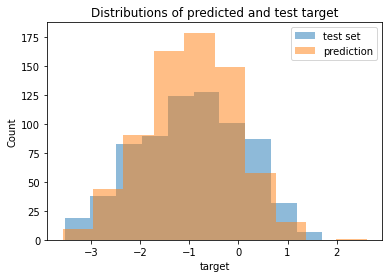

In [83]:
plt.hist(y_test, alpha=0.5, label="test set")
plt.hist(y_predict, alpha=0.5, label="prediction")

plt.title("Distributions of predicted and test target")
plt.xlabel("target")
plt.ylabel("Count")

plt.legend()
plt.show()

Predicted and test targets have identical disributions. The model has more predictions around $-1$. This is expected because targets around $ -1 $ have lowest standard error.

# Conclusions

In this notebook I successfully explored, cleaned, and extracted various features. These features were used to train Linear regression model which predicts readability score. The model could be improved by reducing the number of features and using regularization. Winners in the competition trained BERT models.